### Импорт используемых библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

### Загрузка данных

In [2]:
df = pd.read_csv('hemodynamics.csv',index_col=0)
df.head()

,ID,AGE,Day,SBP,DBP,HR,GT,SpO2,Weight,OUTCOME
0,1,6.0,1,100.0,65.0,108.0,0.0,100.0,20.0,Survived
1,1,6.0,2,100.0,65.0,100.0,0.0,100.0,20.0,Survived
2,1,6.0,3,100.0,65.0,100.0,0.0,100.0,20.0,Survived
3,1,6.0,4,120.0,60.0,100.0,0.0,100.0,20.0,Survived
4,1,6.0,5,100.0,60.0,98.0,0.0,100.0,20.0,Survived


## Гормонотерапия

#### Гипотеза 1: Между пациентами (получавшими и не получавшими гормональную терапию) уже в 1й день имеется определенная разница по параметрам гемодинамики, весу, росту или насыщению крови кислородом (SpO2). Если это так, можно использовать параметры гемодинамики как показания к назначению гормональной терапии (это значительно ускорит начало этого вида терапии).
#### Нулевая гипотеза: разницы нет.

In [3]:
# 1й день - день поступления пациента
df_1 = df[df['Day']==1].copy()
df_1.head()

,ID,AGE,Day,SBP,DBP,HR,GT,SpO2,Weight,OUTCOME
0,1,6.00,1,100.0,65.0,108.0,0.0,100.0,20.0,Survived
6,2,0.42,1,100.0,66.0,115.0,0.0,100.0,7.0,Survived
12,3,13.00,1,120.0,80.0,80.0,1.0,100.0,55.0,Survived
31,4,8.00,1,110.0,65.0,124.0,0.0,100.0,30.0,Survived
36,5,11.00,1,115.0,75.0,110.0,1.0,98.0,50.0,Survived


In [4]:
# Пациенты, которые не получали ГТ имеют параметр GT=0
df_1[df_1['GT']==0].iloc[:,[1,3,4,5,6,7,8]].describe()

,AGE,SBP,DBP,HR,GT,SpO2,Weight
count,115.000000,115.000000,115.000000,115.000000,115.0,115.000000,115.000000
mean,9.192725,106.460870,63.678261,109.913043,0.0,98.252174,35.856522
std,5.549760,17.396454,13.223814,22.587671,0.0,3.942222,21.586197
min,0.250000,70.000000,30.000000,40.000000,0.0,70.000000,6.000000
25%,4.000000,92.500000,55.500000,92.000000,0.0,98.000000,16.000000
50%,9.000000,110.000000,60.000000,110.000000,0.0,100.000000,30.000000
75%,14.500000,120.000000,70.000000,125.000000,0.0,100.000000,50.000000
max,18.000000,159.000000,119.000000,165.000000,0.0,100.000000,103.000000


In [5]:
# Пациенты, которые получали ГТ имеют параметр GT=1
df_1[df_1['GT']==1].iloc[:,[1,3,4,5,6,7,8]].describe()

,AGE,SBP,DBP,HR,GT,SpO2,Weight
count,88.000000,88.000000,88.000000,88.000000,88.0,88.000000,88.000000
mean,8.797348,104.795455,60.034091,111.465909,1.0,97.272727,36.119318
std,5.160294,21.548213,15.818256,24.578726,0.0,8.681765,22.140875
min,0.250000,45.000000,17.000000,54.000000,1.0,26.000000,6.000000
25%,4.000000,90.000000,50.000000,96.000000,1.0,98.000000,18.000000
50%,8.500000,106.500000,60.500000,112.500000,1.0,99.000000,30.000000
75%,13.000000,118.500000,70.000000,122.000000,1.0,100.000000,51.250000
max,17.000000,155.000000,100.000000,172.000000,1.0,100.000000,100.000000


#### Визуализация: значения параметров в двух группах пациентов (получавших гормонотерапию и не получавших)

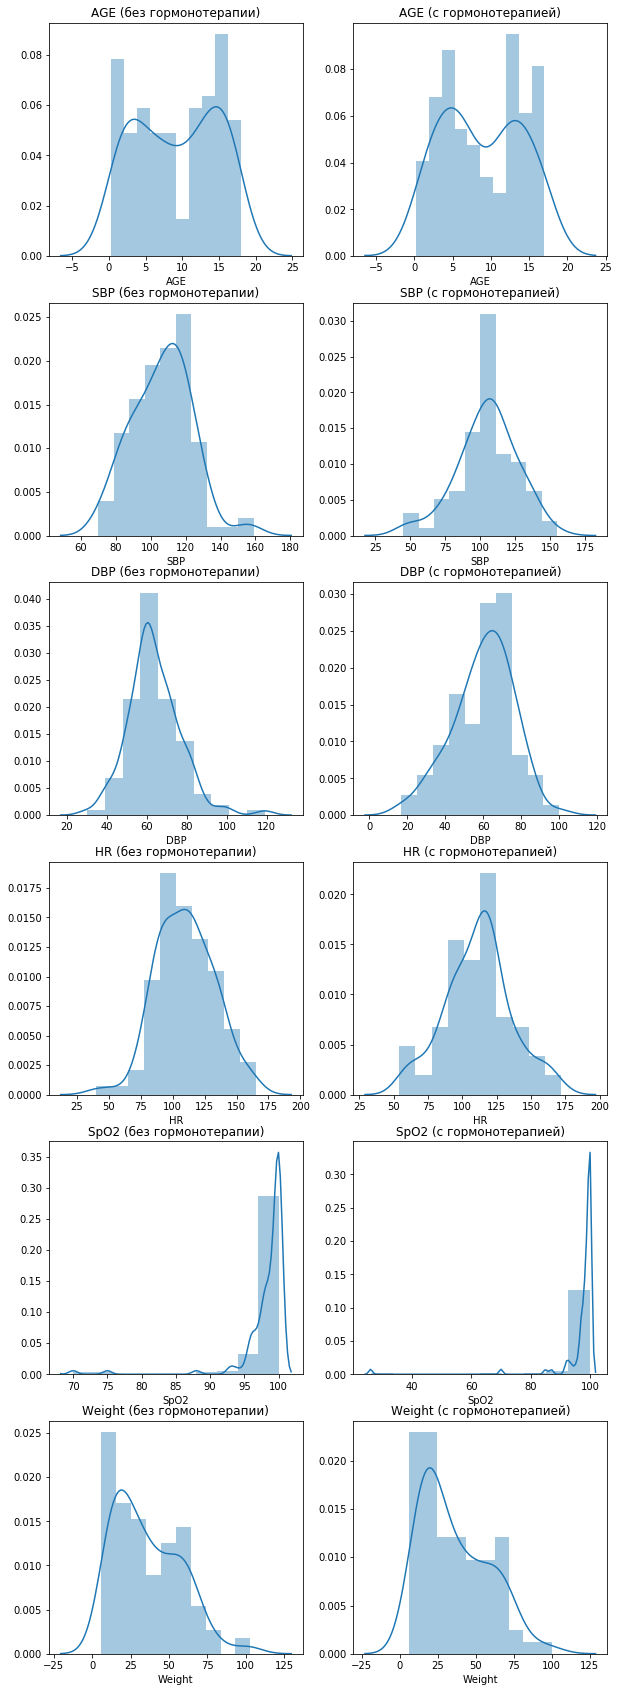

In [6]:
figure,ax = plt.subplots(6,2,figsize=(10,30))
for k,i in enumerate(['AGE','SBP','DBP','HR','SpO2','Weight']):
    sns.distplot(df_1[df_1['GT']==0][i],bins=10,ax=ax[k,0])
    sns.distplot(df_1[df_1['GT']==1][i],bins=10,ax=ax[k,1])
    ax[k,0].set_title(i+' (без гормонотерапии)')
    ax[k,1].set_title(i+' (с гормонотерапией)')

#### На графиках наблюдаются какие-то различия, однако, на первый взгляд, какой-то явной закономерности нет;
#### Предположить, что параметры распределены нормально, на первый взгляд, невозможно: имеется асимметрия графиков, 2 пика, или просто резкое (многократное) преобладание одного значения параметра над другими.
#### т.к. графики далеки от нормального распределения, проверка на значимость различий выполнена с использованием критерия Краскела-Уоллиса

In [7]:
for k,i in enumerate(['AGE','SBP','DBP','HR','SpO2','Weight']):
    group0 = df_1[df_1['GT']==0][i]
    group1 = df_1[df_1['GT']==1][i]
    alpha = 0.05
    test_value, p  = stats.kruskal(group0,group1)
    if alpha<p:
        print(f'Разница по параметру {i} между двумя группами не доказана.')
        print(f'\tСтатистика теста = {test_value}, p-значение = {p}')
    else:
        print(f'По параметру {i} наблюдается статистически достоверная разница между двумя группами.')
        print(f'\tСтатистика теста = {test_value}, p-значение = {p}')

Разница по параметру AGE между двумя группами не доказана.
	Статистика теста = 0.27082231438768856, p-значение = 0.6027806896065662
Разница по параметру SBP между двумя группами не доказана.
	Статистика теста = 0.11443160099865324, p-значение = 0.7351541512429405
Разница по параметру DBP между двумя группами не доказана.
	Статистика теста = 1.112126748561025, p-значение = 0.2916201074564546
Разница по параметру HR между двумя группами не доказана.
	Статистика теста = 0.3353400637681386, p-значение = 0.5625314557621811
Разница по параметру SpO2 между двумя группами не доказана.
	Статистика теста = 0.09908352497067502, p-значение = 0.7529322240495818
Разница по параметру Weight между двумя группами не доказана.
	Статистика теста = 0.003787269311534843, p-значение = 0.9509285271363441


#### На основе полученных данных можно сделать вывод, что гемодинамической основы использование гормональной терапии у данных пациентов нет; это подтверждается графически и с помощью тестом Краскела-Уоллиса. То же самое можно сказать о возрасте, весе и насыщении крови кислородом.

#### Гипотеза 2: те пациенты, которые получали ГТ только в первый день, гемодинамически значимо отличаются от тех пациентов, которые получали ее в последующие дни. Если это так, то параметры гемодинамики можно использовать как показания для продолжительного применения или однократного (1 день) применения ГТ.

In [142]:
# ID пациентов, которые не получали ГТ в первый день
df_1_gt_0 = set(df_1[df_1['GT']==0]['ID'].values)
len(df_1_gt_0)

115

In [143]:
# ID пациентов, которые получали ГТ в первый день
df_1_gt_1 = set(df_1[df_1['GT']==1]['ID'].values)
len(df_1_gt_1)

88

In [144]:
# Составление списков пациенто получавших ГТ более 1 дня и только один день
df_gt_more1day = df.loc[(df['Day']>1)&(df['ID'].isin(df_1_gt_1)),:]
print(f'{df_gt_more1day["ID"].unique().shape[0]} получали ГТ более 1 дня.')
df_gt_only1day = df.loc[df['ID'].isin([i for i in df_1_gt_1 if i not in df_gt_more1day["ID"].values]),:]
print(f'{df_gt_only1day["ID"].unique().shape[0]} получали ГТ только в 1й день')

79 получали ГТ более 1 дня.
9 получали ГТ только в 1й день


In [146]:
# Описательная статистика пациентов, которые получали ГТ в 1й и после первого дня
df_gt_more1day.describe()[1:]

,ID,AGE,Day,SBP,DBP,HR,GT,SpO2,Weight
mean,88.090226,10.312187,7.374060,112.971805,66.095865,103.806391,0.546992,98.349624,42.637218
std,59.549148,5.312586,5.645284,15.943791,13.113593,22.970917,0.498255,2.942311,22.619363
min,3.000000,0.250000,2.000000,60.000000,5.000000,41.000000,0.000000,69.000000,6.000000
25%,34.000000,5.000000,3.000000,105.000000,60.000000,87.750000,0.000000,98.000000,20.000000
50%,85.000000,12.000000,6.000000,114.000000,65.000000,103.000000,1.000000,99.000000,44.000000
75%,116.000000,15.250000,9.000000,120.000000,75.000000,119.000000,1.000000,100.000000,60.000000
max,215.000000,17.000000,31.000000,165.000000,100.000000,186.000000,1.000000,110.000000,100.000000


In [147]:
# Описательная статистика пациентов, которые получали ГТ только в 1й день
df_gt_only1day.describe()[1:]

,ID,AGE,Day,SBP,DBP,HR,GT,SpO2,Weight
mean,165.666667,9.333333,1.0,101.444444,64.444444,114.222222,1.0,96.666667,32.555556
std,36.290495,4.847680,0.0,18.159785,16.786238,19.272894,0.0,10.000000,18.090820
min,80.000000,2.000000,1.0,70.000000,30.000000,96.000000,1.0,70.000000,14.000000
25%,163.000000,6.000000,1.0,90.000000,60.000000,104.000000,1.0,100.000000,22.000000
50%,177.000000,7.000000,1.0,104.000000,68.000000,108.000000,1.0,100.000000,24.000000
75%,187.000000,13.000000,1.0,110.000000,74.000000,120.000000,1.0,100.000000,36.000000
max,195.000000,17.000000,1.0,130.000000,84.000000,160.000000,1.0,100.000000,75.000000


### Гистограммы и QQ-плот для оценки нормальности распределения

Параметр = AGE 
Среднее =  10.312186716791985 std = 5.312585612816814
Параметр = SBP 
Среднее =  112.9718045112782 std = 15.94379116104283
Параметр = DBP 
Среднее =  66.09586466165413 std = 13.113592587479125
Параметр = HR 
Среднее =  103.80639097744361 std = 22.970916610486935
Параметр = SpO2 
Среднее =  98.34962406015038 std = 2.9423109679362107
Параметр = Weight 
Среднее =  42.63721804511278 std = 22.619362532154376


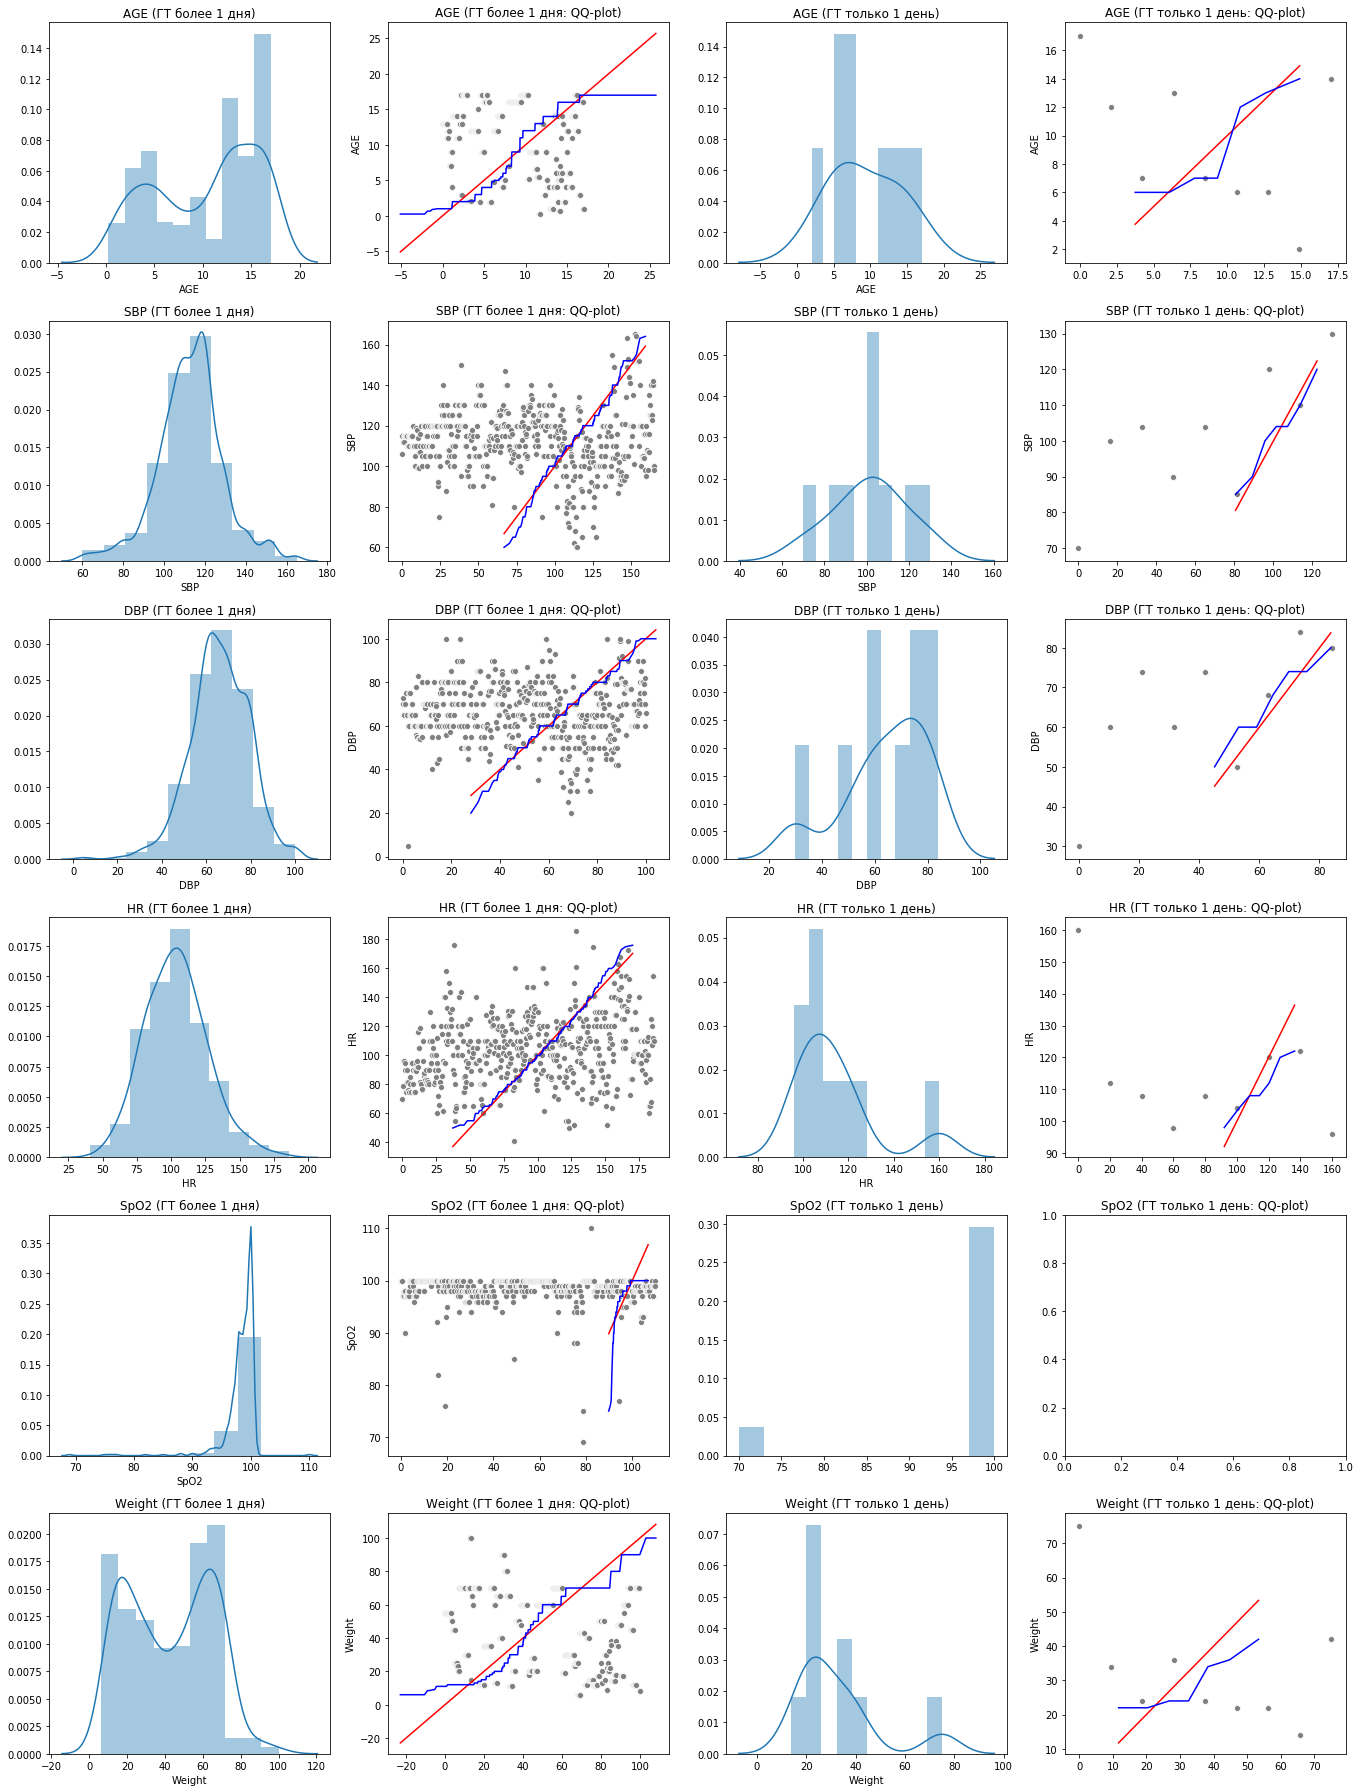

In [148]:
for k,i in enumerate(['AGE','SBP','DBP','HR','SpO2','Weight']):
    print('Параметр =',i,'\nСреднее = ',df_gt_more1day[i].mean(),'std =',df_gt_more1day[i].std(ddof=1))
figure,ax = plt.subplots(6,4,figsize=(19,25))
for k,i in enumerate(['AGE','SBP','DBP','HR','SpO2','Weight']):
    try:
        sns.distplot(df_gt_more1day[i],bins=10,ax=ax[k,0])
        interval = np.linspace(0,1,int(df_gt_more1day[i].count()))
        x = stats.norm.ppf(np.linspace(0,1,int(df_gt_more1day[i].count())),loc=df_gt_more1day[i].mean(),scale=df_gt_more1day[i].std(ddof=1))
        y = np.quantile(df_gt_more1day[i],interval)
        sns.lineplot(x,x,ax=ax[k,1],color='r')
        sns.lineplot(x,y,ax=ax[k,1],color='b')
        sns.scatterplot(np.linspace(0,int(df_gt_more1day[i].max()),int(df_gt_more1day[i].count())),df_gt_more1day[i],ax=ax[k,1],color='grey')
        sns.distplot(df_gt_only1day[i],bins=10,ax=ax[k,2])
        interval = np.linspace(0,1,int(df_gt_only1day[i].count()))
        x = stats.norm.ppf(np.linspace(0,1,int(df_gt_only1day[i].count())),loc=df_gt_only1day[i].mean(),scale=df_gt_only1day[i].std(ddof=1))
        y = np.quantile(df_gt_only1day[i],interval)
        sns.lineplot(x,x,ax=ax[k,3],color='r')
        sns.lineplot(x,y,ax=ax[k,3],color='b')
        sns.scatterplot(np.linspace(0,int(df_gt_only1day[i].max()),int(df_gt_only1day[i].count())),df_gt_only1day[i],ax=ax[k,3],color='grey')
        ax[k,0].set_title(i+' (ГТ более 1 дня)')
        ax[k,1].set_title(i+' (ГТ более 1 дня: QQ-plot)')
        ax[k,2].set_title(i+' (ГТ только 1 день)')
        ax[k,3].set_title(i+' (ГТ только 1 день: QQ-plot)')
        plt.tight_layout()

    except Exception:
        ax[k,0].set_title(i+' (ГТ более 1 дня)')
        ax[k,1].set_title(i+' (ГТ более 1 дня: QQ-plot)')
        ax[k,2].set_title(i+' (ГТ только 1 день)')
        ax[k,3].set_title(i+' (ГТ только 1 день: QQ-plot)')
        plt.tight_layout()
        pass

### По представленным данным нельзя говорить о нормальном распределении. Разница между двумя группами по параметрам оценвалась тестом Краскела-Уоллиса.

In [65]:
for k,i in enumerate(['AGE','SBP','DBP','HR','SpO2','Weight']):
    group0 = df_gt_more1day[i]
    group1 = df_gt_only1day[i]
    alpha = 0.05
    test_value, p  = stats.kruskal(group0,group1)
    if alpha<p:
        print(f'Разница по параметру {i} между двумя группами не доказана.')
        print(f'\tСтатистика теста = {test_value}, p-значение = {p}')
    else:
        print(f'По параметру {i} наблюдается статистически достоверная разница между двумя группами.')
        print(f'\tСтатистика теста = {test_value}, p-значение = {p}')

Разница по параметру AGE между двумя группами не доказана.
	Статистика теста = 0.25627016835970606, p-значение = 0.6126942573171913
По параметру SBP наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 3.921188107500018, p-значение = 0.04768117140617504
Разница по параметру DBP между двумя группами не доказана.
	Статистика теста = 0.0015946319466958554, p-значение = 0.9681466670835848
Разница по параметру HR между двумя группами не доказана.
	Статистика теста = 1.949907738290852, p-значение = 0.16259679315058895
По параметру SpO2 наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 5.301667407337234, p-значение = 0.021305020216253554
Разница по параметру Weight между двумя группами не доказана.
	Статистика теста = 1.0811910045680164, p-значение = 0.2984312728864733


### Наблюдается значимое различие между двумя группами по систолическому давлению. По этому же показателю графики (гистограмма, но не QQ-плот) выглядят так, как будто имеют некое нормальное распределение. Поэтому можно проанализировать этот параметр параметрическим методом.
### По параметру SpO2 недостаточно данных - на графике из-за этого даже не отображается кривая распределния. Необходимо накопить больше данных, чтобы делать выводы.

In [68]:
from scipy.stats import ttest_ind
group0 = df_gt_more1day['SBP']
group1 = df_gt_only1day['SBP']
stat, p = ttest_ind(group0,group1)
alpha = 0.05
print('Статистика теста = ',stat, '\np-value (критическое значение) = ', p, '\nуровень alpha = ',alpha)

Статистика теста =  2.1461528130216783 
p-value (критическое значение) =  0.032306583287101974 
уровень alpha =  0.05


### p-значение меньше уровня альфа, значит можно отвергнуть нулевую гипотезу о равенстве параметров между группами пациентов по систолическому давленю.
### по остальным параметрам разница между группами не выявлена.

## Исход заболевания

#### Имеется сильная асимметрия выборки: большинство пациентов выжили; 19 - умерли.

In [172]:
pd.DataFrame(df.groupby('ID')['OUTCOME'].value_counts()).drop(columns='OUTCOME').reset_index(1)['OUTCOME'].value_counts()

Survived    184
Died         19
Name: OUTCOME, dtype: int64

In [184]:
# т.к. выборки разного размера, в одной из них - мало данных, распределение не нормальное (графики ниже), воспользуемся тестом Краскела-Уоллиса
for k,i in enumerate(['AGE','SBP','DBP','HR','SpO2','Weight']):
    group0 = df_1[df_1['OUTCOME']=='Survived'][i]
    group1 = df_1[df_1['OUTCOME']=='Died'][i]
    alpha = 0.05
    test_value, p  = stats.kruskal(group0,group1)
    if alpha<p:
        print(f'Разница по параметру {i} между двумя группами не доказана.')
        print(f'\tСтатистика теста = {test_value}, p-значение = {p}')
    else:
        print(f'По параметру {i} наблюдается статистически достоверная разница между двумя группами.')
        print(f'\tСтатистика теста = {test_value}, p-значение = {p}')

Разница по параметру AGE между двумя группами не доказана.
	Статистика теста = 0.09495580315700308, p-значение = 0.7579689611994188
По параметру SBP наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 4.828301821551247, p-значение = 0.02799619328956503
По параметру DBP наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 6.073802699812108, p-значение = 0.013720126629866063
Разница по параметру HR между двумя группами не доказана.
	Статистика теста = 0.029024733521036107, p-значение = 0.8647219410260173
По параметру SpO2 наблюдается статистически достоверная разница между двумя группами.
	Статистика теста = 11.057479683274263, p-значение = 0.0008833013139219262
Разница по параметру Weight между двумя группами не доказана.
	Статистика теста = 0.01467232534088532, p-значение = 0.9035885630719585


### Тест Краскела-Уоллиса показывает наличие значимой разницы по систолическому давлению и SpO2.
### На графиках четкой разницы не видно (см. ниже). Возможно, стоит попытаться использовать данные находки в комбинации с другими параметрами в машинном обучении.

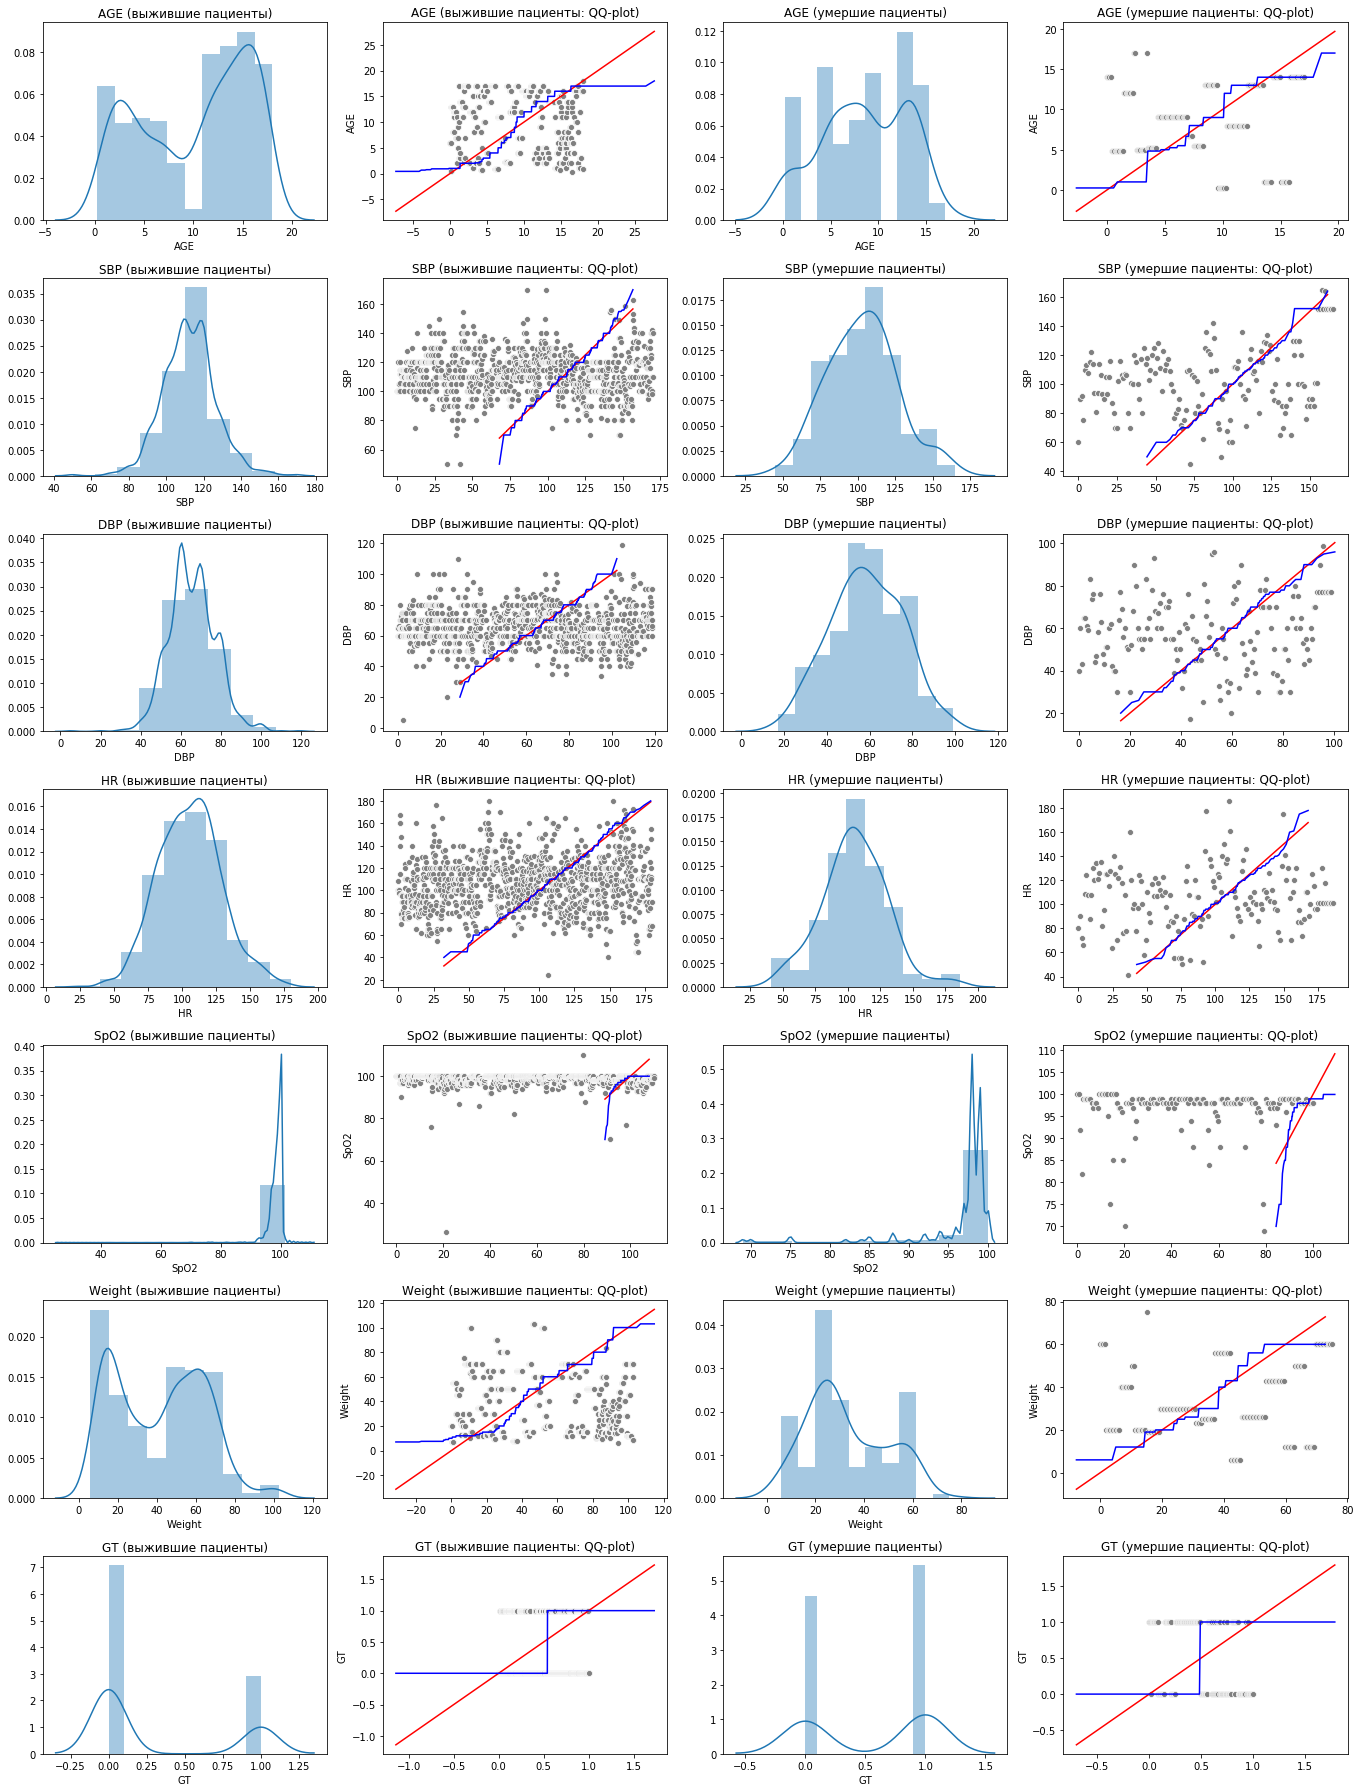

In [182]:
group0 = df[df['OUTCOME']=='Survived']
group1 = df[df['OUTCOME']=='Died']
figure,ax = plt.subplots(7,4,figsize=(19,25))
for k,i in enumerate(['AGE','SBP','DBP','HR','SpO2','Weight','GT']):
    try:
        sns.distplot(group0[i],bins=10,ax=ax[k,0])
        interval = np.linspace(0,1,int(group0[i].count()))
        x = stats.norm.ppf(np.linspace(0,1,int(group0[i].count())),loc=group0[i].mean(),scale=group0[i].std(ddof=1))
        y = np.quantile(group0[i],interval)
        sns.lineplot(x,x,ax=ax[k,1],color='r')
        sns.lineplot(x,y,ax=ax[k,1],color='b')
        sns.scatterplot(np.linspace(0,int(group0[i].max()),int(group0[i].count())),group0[i],ax=ax[k,1],color='grey')
        sns.distplot(group1[i],bins=10,ax=ax[k,2])
        interval = np.linspace(0,1,int(group1[i].count()))
        x = stats.norm.ppf(np.linspace(0,1,int(group1[i].count())),loc=group1[i].mean(),scale=group1[i].std(ddof=1))
        y = np.quantile(group1[i],interval)
        sns.lineplot(x,x,ax=ax[k,3],color='r')
        sns.lineplot(x,y,ax=ax[k,3],color='b')
        sns.scatterplot(np.linspace(0,int(group1[i].max()),int(group1[i].count())),group1[i],ax=ax[k,3],color='grey')
        ax[k,0].set_title(i+' (выжившие пациенты)')
        ax[k,1].set_title(i+' (выжившие пациенты: QQ-plot)')
        ax[k,2].set_title(i+' (умершие пациенты)')
        ax[k,3].set_title(i+' (умершие пациенты: QQ-plot)')
        plt.tight_layout()

    except Exception:
        ax[k,0].set_title(i+' (выжившие пациенты)')
        ax[k,1].set_title(i+' (выжившие пациенты: QQ-plot)')
        ax[k,2].set_title(i+' (умершие пациенты)')
        ax[k,3].set_title(i+' (умершие пациенты: QQ-plot)')
        plt.tight_layout()
        pass